# Challenge 1

Read in the `2013_movies.csv` data set, parsing dates to `datetime64` and explicitly passing a date parsing callable:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

dtypes = {'Rating': 'category'}

# NOTE: this token may change
path = ('https://raw.githubusercontent.com/thisismetis/nyc18_ds14/master/'
        'challenges/challenges_data/2013_movies.csv?'
        'token=AX_7hAm1CevQTTc4G0GsaCUTsjh9T7qQks5ac2VGwA%3D%3D')

df = pd.read_csv(path, dtype=dtypes, parse_dates=['ReleaseDate'], 
                 date_parser=lambda dt: pd.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))
df.columns = df.columns.str.lower()

In [2]:
df.head(3)

,title,budget,domestictotalgross,director,rating,runtime,releasedate
0,The Hunger Games...,1.3000e+08,424668047,Francis Lawrence,PG-13,146,2013-11-22
1,Iron Man 3,2.0000e+08,409013994,Shane Black,PG-13,129,2013-05-03
2,Frozen,1.5000e+08,400738009,Chris BuckJennif...,PG,108,2013-11-22


Before doing any statistiacl modelling, let's first clean up `director`, which sometimes consists of multiple directors with their names "smushed" together.  For example, we currently have entires like:

In [3]:
df['director'].iloc[2]

'Chris BuckJennifer Lee'

_However_, we want to be careful _not_ to catch cases like: "Chris DeLong" (and accidentally split this to "Chris De" / "Long."

The following regex is [not absolutely foolproof](http://answers.google.com/answers/threadview/id/711284.html) but should get us 99% of the way there.  It looks for "lU" patterns where "l" is a lowercase letter, "U" is an uppercase letter and the two together are not preceded by "De," "Le,", "Da,", "Mac,", "Mc,", or "Van."

In [4]:
import re

splitter = re.compile('[^(De|Le|Da|Mac|Mc|Van)](?P<lower>[a-z])(?P<upper>[A-Z])')
df['director'] = df['director'].str.replace(splitter, r'\g<lower>; \g<upper>')

And from this let's get the number of directors (assuming that names don't naturally contain semicolons):

In [5]:
df['num_directors'] = df['director'].str.count(';').add(1)

At first glance we do have some missing data at various spots:

In [6]:
df[df['num_directors'].isnull()].head(3)

,title,budget,domestictotalgross,director,rating,runtime,releasedate,num_directors
25,Cloudy with a Ch...,7.8000e+07,119793567,NaN,PG,95,2013-09-27,NaN
71,Jurassic Park 3D,1.0000e+07,45385935,NaN,PG-13,127,2013-04-05,NaN
73,Instructions Not...,NaN,44467206,NaN,PG-13,115,2013-08-30,NaN


Upfront, let's also "dummify" `rating` and bin (discretize) `runtime` into quintiles, then encode the quintiles:

In [7]:
df = pd.get_dummies(df, columns=['rating'], prefix='rtg', drop_first=True)

In [8]:
df['runtime_bin'] = pd.qcut(df['runtime'], q=5, labels=range(1,6))
df = pd.get_dummies(df, columns=['runtime_bin'], drop_first=True)

Lastly let's upsample `releasedate` to create new fields that may help detect seasonality trends:

In [9]:
df['quarter'] = df['releasedate'].dt.quarter
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [10]:
df.iloc[:3, :12]

,title,budget,domestictotalgross,director,runtime,releasedate,num_directors,rtg_PG,rtg_PG-13,rtg_R,runtime_bin_2,runtime_bin_3
0,The Hunger Games...,1.3000e+08,424668047,Francis Lawrence,146,2013-11-22,1.0,0,1,0,0,0
1,Iron Man 3,2.0000e+08,409013994,Shane Black,129,2013-05-03,1.0,0,1,0,0,0
2,Frozen,1.5000e+08,400738009,Chris BuckJennif...,108,2013-11-22,1.0,1,0,0,0,1


Finally let's drop invalid data:

In [11]:
n = len(df)
df.dropna(inplace=True)
print('Dropped {} of {} total samples.'.format(n - len(df), n))

Dropped 13 of 100 total samples.


<font color="blue"> Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like `domestic total gross`). </font>

In [12]:
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS

df = add_constant(df)
model = OLS(endog=df['domestictotalgross'], exog=df['const']).fit()

<font color="blue"> How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed? </font>

Our only coefficient, $\beta_0$, is equal to the mean of $y$ (the endogenous variable) in this case.

In the matrix formulation of multiple regression we have:

$$y = \beta_0 + \beta_1X_1 + ... + \beta_nX_n$$

But implicitly, $\beta_0$ is multiplied by a **column vector of ones:**

$$y = \beta_0 1 + \beta_1X_1 + ... + \beta_nX_n$$

In [13]:
np.allclose(model.params.iat[0], df['domestictotalgross'].mean())

True

In other words, the intercept $\beta_0$ is the mathematical expectation of $Y$ if all other terms in the design matrix $X$ are zero.  Similarly, the unconditioned expectation of $Y$ is its mean.

<font color="blue"> Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed? </font>

The residuals are skewed right, exactly like the endogenous vector.

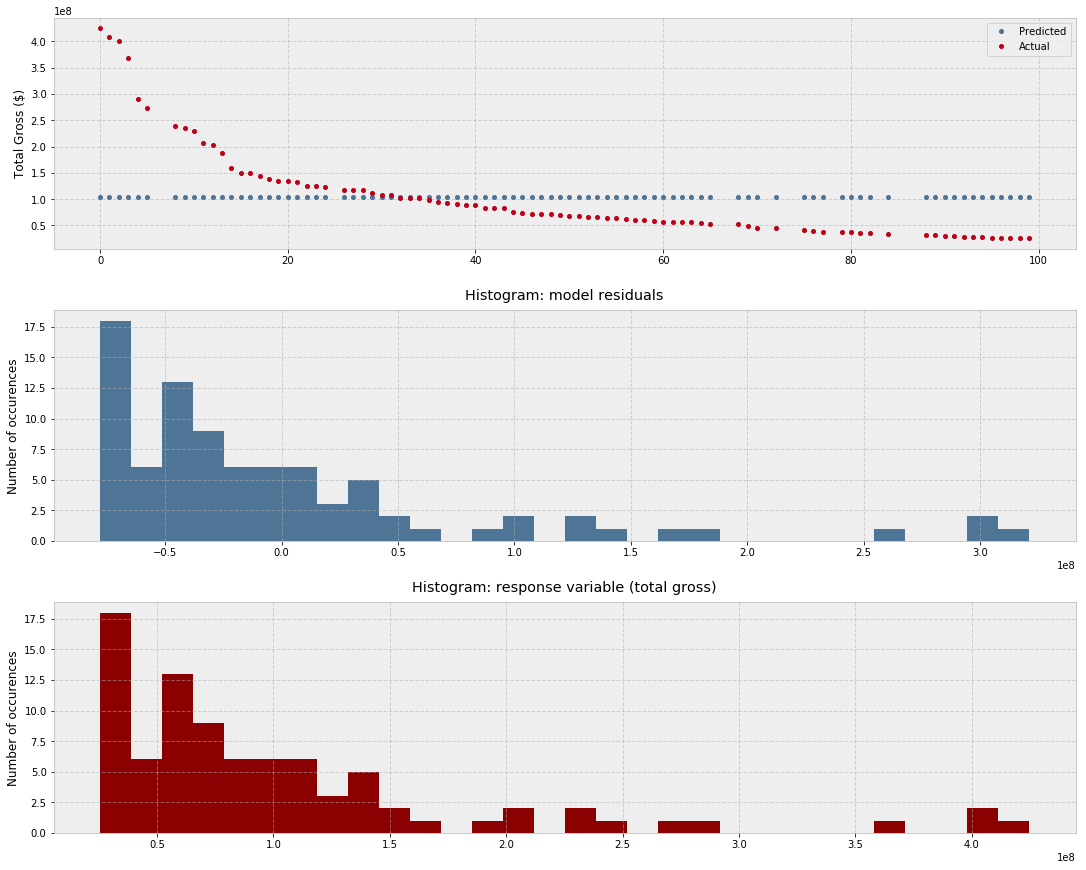

In [14]:
pred = model.predict(df['const'])
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(pred, linestyle='')
ax1.plot(df['domestictotalgross'], linestyle='')
ax1.legend(['Predicted', 'Actual'])
ax1.set_ylabel('Total Gross ($)')
ax2.hist(model.resid, bins=30)
ax2.set_title('Histogram: model residuals')
ax2.set_ylabel('Number of occurences')
ax3.hist(df['domestictotalgross'], bins=30, color='darkred')
ax3.set_title('Histogram: response variable (total gross)')
ax3.set_ylabel('Number of occurences')
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

# Challenge 2

<font color="blue"> Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model? </font>

In [15]:
x = df[['const', 'budget']]
model = OLS(endog=df['domestictotalgross'], exog=x).fit()

In [16]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     domestictotalgross   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     33.43
Date:                Thu, 25 Jan 2018   Prob (F-statistic):           1.19e-07
Time:                        16:22:59   Log-Likelihood:                -1700.0
No. Observations:                  87   AIC:                             3404.
Df Residuals:                      85   BIC:                             3409.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.443e+07    1.3e+07      3.418      0.0

We can draw a number of immediate conclusions:

- Both the intercept & first coefficient are significant at the 1% level.
- The `budget` coefficient of 0.7846 implies that there is a \$0.78 return for each incremental dollar spent.
- The model's expalanatory power is okay but certainly not great at $R^2 = 0.286$.

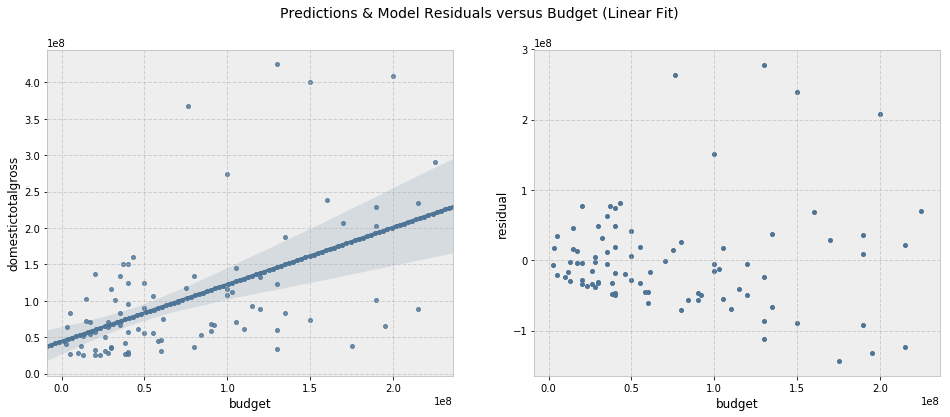

In [17]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
sns.regplot(x=df['budget'], y=df['domestictotalgross'], ax=ax1)
ax2.scatter(x=df['budget'], y=model.resid)
ax2.set_xlabel('budget')
ax2.set_ylabel('residual')
fig.suptitle('Predictions & Model Residuals versus Budget (Linear Fit)', fontsize=14);

Another observation follows: the variance of residuals increases as budget increases.  One reason is that a linear fit seems to be suboptimal; taking the logarithm of `budget` might work better here, as `domestictotalgross` itself is heteroskedastic.

/Applications/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


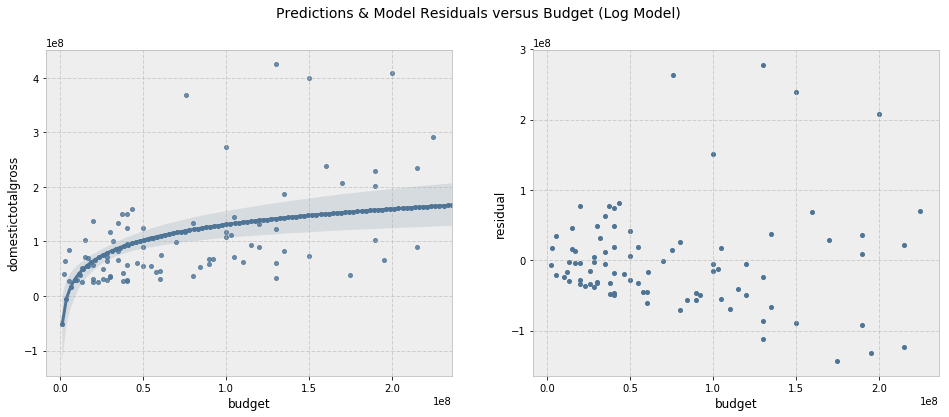

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
sns.regplot(x=df['budget'], y=df['domestictotalgross'], ax=ax1, logx=True)
ax2.scatter(x=df['budget'], y=model.resid)
ax2.set_xlabel('budget')
ax2.set_ylabel('residual')
fig.suptitle('Predictions & Model Residuals versus Budget (Log Model)', fontsize=14);

**Bonus**: here's a nonparametric [lowess model](https://en.wikipedia.org/wiki/Local_regression) (locally weighted linear regression):

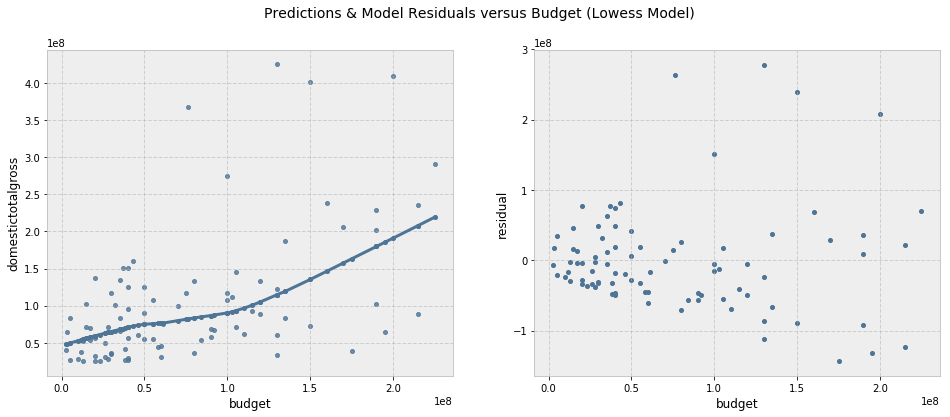

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
sns.regplot(x=df['budget'], y=df['domestictotalgross'], ax=ax1, lowess=True)
ax2.scatter(x=df['budget'], y=model.resid)
ax2.set_xlabel('budget')
ax2.set_ylabel('residual')
fig.suptitle('Predictions & Model Residuals versus Budget (Lowess Model)', fontsize=14);

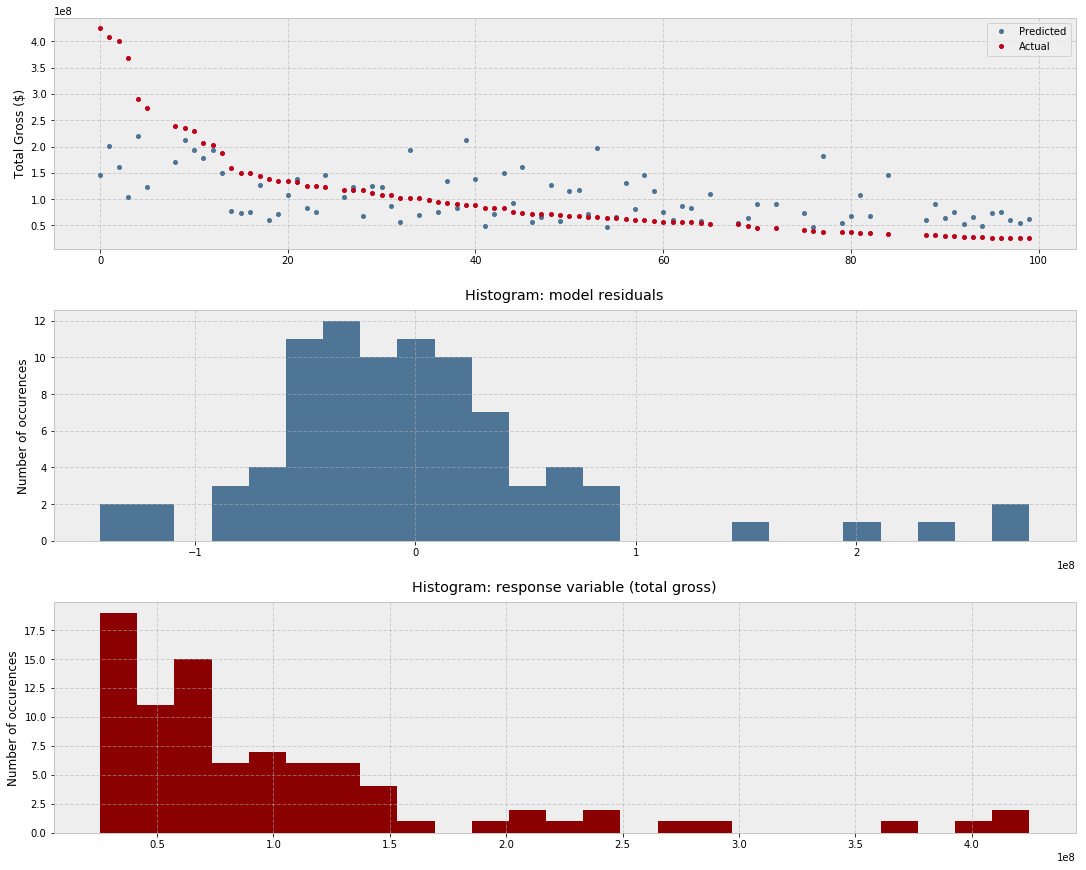

In [20]:
pred = model.predict(x)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(pred, linestyle='')
ax1.plot(df['domestictotalgross'], linestyle='')
ax1.legend(['Predicted', 'Actual'])
ax1.set_ylabel('Total Gross ($)')
ax2.hist(model.resid, bins=25)
ax2.set_title('Histogram: model residuals')
ax2.set_ylabel('Number of occurences')
ax3.hist(df['domestictotalgross'], bins=25, color='darkred')
ax3.set_title('Histogram: response variable (total gross)')
ax3.set_ylabel('Number of occurences')
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

In [21]:
df['budget_sqd'] = df['budget'].pow(2)
x = df[['const', 'budget_sqd']]
model = OLS(endog=df['domestictotalgross'], exog=x).fit()

In [22]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     domestictotalgross   R-squared:                      -0.154
Model:                            OLS   Adj. R-squared:                 -0.154
Method:                 Least Squares   F-statistic:                      -inf
Date:                Thu, 25 Jan 2018   Prob (F-statistic):                nan
Time:                        16:23:10   Log-Likelihood:                -1720.6
No. Observations:                  87   AIC:                             3443.
Df Residuals:                      86   BIC:                             3446.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.402e-25   2.49e-26      9.636      0.0

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

x = df[['const', 'budget']]
y=df['domestictotalgross']

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X=x, y=y)
pipeline.score(x, y)

0.28247354426595661

# Challenge 3

<font color="blue"> Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model? </font>

In [24]:
df2 = df.filter(regex='(domestictotalgross|budget|rating)').dropna()

In [25]:
x = add_constant(df2.filter(regex='budget|rating'))
model = OLS(endog=df2['domestictotalgross'], exog=x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     domestictotalgross   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     25.86
Date:                Thu, 25 Jan 2018   Prob (F-statistic):           2.16e-06
Time:                        15:12:35   Log-Likelihood:                -1702.8
No. Observations:                  87   AIC:                             3410.
Df Residuals:                      85   BIC:                             3415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.791e-08   5.78e-09      6.555      0.0

# Challenge 4

**Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.**

We added a number of derived features in Challenge 1:

In [24]:
df.columns

Index(['const', 'title', 'budget', 'domestictotalgross', 'director', 'runtime',
       'releasedate', 'num_directors', 'rtg_PG', 'rtg_PG-13', 'rtg_R',
       'runtime_bin_2', 'runtime_bin_3', 'runtime_bin_4', 'runtime_bin_5',
       'quarter_2', 'quarter_3', 'quarter_4', 'budget_sqd'],
      dtype='object')

In [30]:
x = df.drop(['title', 'domestictotalgross', 'director',
             'releasedate'], axis=1)
x.to_clipboard()
model = OLS(endog=df['domestictotalgross'], exog=x, hasconst=True).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     domestictotalgross   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     34.35
Date:                Thu, 25 Jan 2018   Prob (F-statistic):           8.51e-08
Time:                        16:26:09   Log-Likelihood:                -1699.6
No. Observations:                  87   AIC:                             3403.
Df Residuals:                      85   BIC:                             3408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3618.9513   1415.728      2.556

In [31]:
x.drop('const', axis=1)

,budget,runtime,num_directors,rtg_PG,rtg_PG-13,rtg_R,runtime_bin_2,runtime_bin_3,runtime_bin_4,runtime_bin_5,quarter_2,quarter_3,quarter_4,budget_sqd
0,1.3000e+08,146,1.0,0,1,0,0,0,0,1,0,0,1,1.6900e+16
1,2.0000e+08,129,1.0,0,1,0,0,0,0,1,1,0,0,4.0000e+16
2,1.5000e+08,108,1.0,1,0,0,0,1,0,0,0,0,1,2.2500e+16
3,7.6000e+07,98,2.0,1,0,0,1,0,0,0,0,1,0,5.7760e+15
4,2.2500e+08,143,1.0,0,1,0,0,0,0,1,1,0,0,5.0625e+16
5,1.0000e+08,91,1.0,0,1,0,0,0,0,0,0,0,1,1.0000e+16
8,1.6000e+08,130,1.0,0,1,0,0,0,0,1,1,0,0,2.5600e+16
9,2.1500e+08,127,1.0,1,0,0,0,0,1,0,0,0,0,4.6225e+16
10,1.9000e+08,123,1.0,0,1,0,0,0,1,0,1,0,0,3.6100e+16
11,1.7000e+08,120,1.0,0,1,0,0,0,1,0,0,0,1,2.8900e+16


In [33]:
model2 = LinearRegression().fit(X=x.drop('const', axis=1), y=df['domestictotalgross'])

In [35]:
model2.intercept_

6105903.6824644655

In [36]:
model.rsquared

0.28781386111078311

In [37]:
model2.score(x.drop('const', axis=1), df['domestictotalgross'])

0.28780649166856731

In [34]:
pd.DataFrame({'statsmodels': model.params,
              'sklearn': np.insert(model2.coef_, 0, model2.intercept_)})

,sklearn,statsmodels
const,6.1059e+06,3.6190e+03
budget,6.7561e-01,6.9742e-01
runtime,3.9614e+05,4.3509e+05
num_directors,-6.7486e+02,3.5446e+03
rtg_PG,-3.3200e+03,-5.9691e+02
rtg_PG-13,1.4643e+03,1.1499e+03
rtg_R,1.8557e+03,3.0659e+03
runtime_bin_2,-3.5722e+03,-5.9830e+02
runtime_bin_3,-1.2026e+02,4.8658e+02
runtime_bin_4,2.7138e+03,1.2005e+03


In [39]:
model = OLS(endog=df['domestictotalgross'], exog=df[['const', 'budget']], hasconst=True).fit()
model2 = LinearRegression().fit(X=df['budget'].values[:, None], y=df['domestictotalgross'])

In [40]:
model.rsquared

0.28230037692954868

In [42]:
model2.score(df['budget'].values[:, None], df['domestictotalgross'])

0.28230037692954857

In [43]:
model.params

const     4.4431e+07
budget    7.8306e-01
dtype: float64

In [44]:
model2.intercept_, model2.coef_

(44430625.617948361, array([ 0.7831]))

# Challenge 5

Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, df['domestictotalgross'], random_state=444)

In [44]:
model = LinearRegression(n_jobs=-1).fit(X_train, y_train)
print('In-sample R-squared:', model.score(X_train, y_train))
print('Out-of-sample R-squared:', model.score(X_test, y_test))

In-sample R-squared: 0.41308428848
Out-of-sample R-squared: -1.56181484646


Ouch.  Let's try some model-based feature selection:

In [45]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Select all features that have a feature_importance above median
select = SelectFromModel(
    RandomForestRegressor(n_estimators=1000, random_state=444, max_depth=10),
    threshold="median")

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_l1.shape))

X_test_l1 = select.transform(X_test)
score = LinearRegression(n_jobs=-1)\
    .fit(X_train_l1, y_train)\
    .score(X_test_l1, y_test)
print('Test score: {:.3f}'.format(score))

X_train.shape: (65, 15)
X_train_l1.shape: (65, 8)
Test score: -1.507


And also some recursive feature elimination:

In [52]:
from sklearn.feature_selection import RFE

select = RFE(LinearRegression(n_jobs=-1), n_features_to_select=4)
select.fit(X_train, y_train)
X_train_rfe= select.transform(X_train)
print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_rfe.shape))

X_test_rfe= select.transform(X_test)
model = LinearRegression(n_jobs=-1).fit(X_train_rfe, y_train)
print('Test score: {:.3f}'.format(model.score(X_test_rfe, y_test)))

X_train.shape: (65, 15)
X_train_l1.shape: (65, 4)
Test score: -0.927


No dice.  